# PCA (Principal component analysis) - Análise de componentes principais

## 1 - Usos

- Aplicar PCA em uma base de dados de reconhecimento da atividade humana
- Avaliar a acurácia de um modelo após a plicação do PCA

In [417]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

#### Como usa?

Primeiramente, vamos ver como usa o algoritmo de componentes principais de uma forma bem pragmática, retomando o problema de classificação de atividade humana por dados de acelerômetro e giroscópio de celular na base [HAR](). Já discutimos essa base quando falamos de árvores de classificação multinomial.

O contexto é o seguinte: esta base começa a ter um tamanho razoável para um hardware de computador pessoal: ela possui 7000 registros na base de treinamento e 3000 registros na base de testes, cada uma contendo 561 variáveis. Dessa forma, o processamento de um algoritmo nessa base pode levar um tempo razoável se considerarmos todas as variáveis - ainda considerando os diversos ajustes no algoritmo e uma eventual validação cruzada.

Assim, se quisermos ganhar agilidade, uma boa ideia é fazer redução de dimensionalidade - ou seja, trabalhar com um número menor de variáveis, com a menor perda de informação possível. Digamos que queremos limitar o nosso algoritmo a apenas 3 variáveis - é claro que vamos perder a informação das demais, mas será que não podemos minimizar essa perda construindo 3 novas variáveis através de combinações das 561? 

Em poucas linhas, é esse o uso mais frequente da análise de componentes principais (PCA para *principal component analysis*): ela fornece novas variáveis chamadas de componentes principais, que são combinações lineares das 561 variáveis, e podem ser utilizadas em menor número de modo a minimizar a perda de informação. A técnica se baseia em álgebra linear, mas no momento vamos nos focar no uso, depois falamos um pouco sobre a mecânica.

In [5]:
# Carregando dados

filename_features = './input/features.txt'
filename_labels = './input/activity_labels.txt'

filename_subtrain = './input/train/subject_train.txt'
filename_xtrain = './input/train/X_train.txt'
filename_ytrain = './input/train/y_train.txt'

filename_subtest = './input/test/subject_test.txt'
filename_xtest = './input/test/X_test.txt'
filename_ytest = './input/test/y_test.txt'

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep='#')
labels = pd.read_csv(filename_labels, header=None, sep=r'\s+',
                     names=['cod_label', 'label'])

# Dados de treino
subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, sep=r'\s+', header=None, names=features.nome_var)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])
# Dados de teste
subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(filename_xtest, sep=r'\s+', header=None, names=features.nome_var)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

In [6]:
labels

,cod_label,label
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING


In [7]:
X_train.shape

(7352, 561)

In [8]:
y_train.value_counts()

cod_label
6            1407
5            1374
4            1286
1            1226
2            1073
3             986
Name: count, dtype: int64

##### Dividindo a base em treino, validação e teste

Vamos dividir a base de treino em Treino e Validação, para fazermos o *post-pruning* da árvore e avaliar o modelo final na base de testes.

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

##### Treinando a árvore

Para o post-pruning utilizaremos o *complexity cost pruning path*.

**Começando sem fazermos redução de dimensionalidade**

In [13]:
%%time

path = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

CPU times: total: 3min 10s
Wall time: 3min 11s


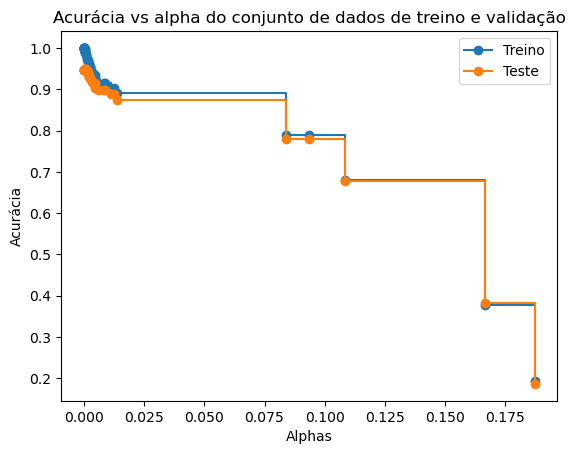

In [14]:
train_score = [clf.score(X_train, y_train) for clf in clfs]
valid_score = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel('Alphas')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia vs alpha do conjunto de dados de treino e validação')
ax.plot(ccp_alphas, train_score, marker='o', label='Treino', drawstyle='steps-post')
ax.plot(ccp_alphas, valid_score, marker='o', label='Teste', drawstyle='steps-post')
ax.legend()
plt.show()

In [15]:
# Verificando a acurácia
# ind_melhor_arvore = len(valid_score) - valid_score[::-1].index(max(valid_score)) - 1 
ind_melhor_arvore = valid_score.index(max(valid_score))
melhor_arvore = clfs[ind_melhor_arvore]

acc_train = train_score[ind_melhor_arvore]
acc_valid = valid_score[ind_melhor_arvore]
acc_test = melhor_arvore.score(X_test, y_test)

print('--> A acuáracia da melhor árvore na base de treino foi {:.2f}%'.format(acc_train*100))
print('--> A acuáracia da melhor árvore na base de validação foi {:.2f}%'.format(acc_valid*100))
print('--> A acuáracia da melhor árvore na base de teste foi {:.2f}%'.format(acc_test*100))

--> A acuáracia da melhor árvore na base de treino foi 98.60%
--> A acuáracia da melhor árvore na base de validação foi 94.99%
--> A acuáracia da melhor árvore na base de teste foi 83.95%


## 2 - Como faz?

- Implementação do PCA em Python utilizando o pacote sklearn
- Avaliação da qualidade de um modelo treinado com componentes principais

#### Construindo um modelo PCA (Análise de componentes principais)

Vamos utilizar as 3 primeiras componentes principais, são aquelas que mais trazem informações do nosso banco de dados. 

- Três variáveis (as componentes principais)


In [18]:
%%time

# Selecionando as componentes principais
prcomp = PCA().fit(X_train)

# Calculando as componentes principais (ordenadas em ordem crescente)
pc_treino = prcomp.transform(X_train)
pc_valida = prcomp.transform(X_valid)
pc_teste = prcomp.transform(X_test)

CPU times: total: 1.75 s
Wall time: 361 ms


In [19]:
# Dimensão das componentes ordenadas

pc_treino.shape, pc_valida.shape, pc_teste.shape

((5514, 561), (1838, 561), (2947, 561))

Vamos agora selecionar somente as `n` primeiras componentes principais. Vamos começar com `n=3`. Vamos jogá-las em um dataframe (somente por ser uma estrutura familiar)

In [21]:
n = 3

colunas = ['cp'+str(x+1) for x in list(range(n))]

# [:,:n] Formato para obter os três principais para cada coluna, uma vez que cada elemento to array é composto por uma linha
pc_train = pd.DataFrame(pc_treino[:,:n], columns=colunas) 
pc_valid = pd.DataFrame(pc_valida[:,:n], columns=colunas)
pc_test = pd.DataFrame(pc_teste[:,:n], columns=colunas)

In [22]:
pc_train.shape, pc_valid.shape, pc_test.shape

((5514, 3), (1838, 3), (2947, 3))

In [23]:
pc_train.head()

,cp1,cp2,cp3
0,-5.512125,0.352963,1.913556
1,-5.763849,-0.778332,0.144694
2,-6.018419,-0.702393,2.048432
3,-5.228827,-0.116168,2.109243
4,-5.906228,0.422996,1.644683


In [24]:
pc_valid.head()

,cp1,cp2,cp3
0,-5.896403,-1.015703,1.694825
1,-5.720996,-1.389977,2.105309
2,-5.753012,0.489031,1.755815
3,6.777120,-1.088302,0.736149
4,3.502376,2.223018,-0.298857


In [25]:
pc_test.head()

,cp1,cp2,cp3
0,-2.756126,1.278640,0.666297
1,-4.399699,0.832252,1.122523
2,-5.048490,-0.278276,1.690526
3,-5.165283,-0.143262,1.833142
4,-5.091926,0.633418,1.871261


##### Criando modelos com a nova base

In [27]:
%%time

# Gerando as árvores para as componentes principais
path = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

CPU times: total: 3.19 s
Wall time: 3.16 s


##### Avaliando a acurácia do modelo



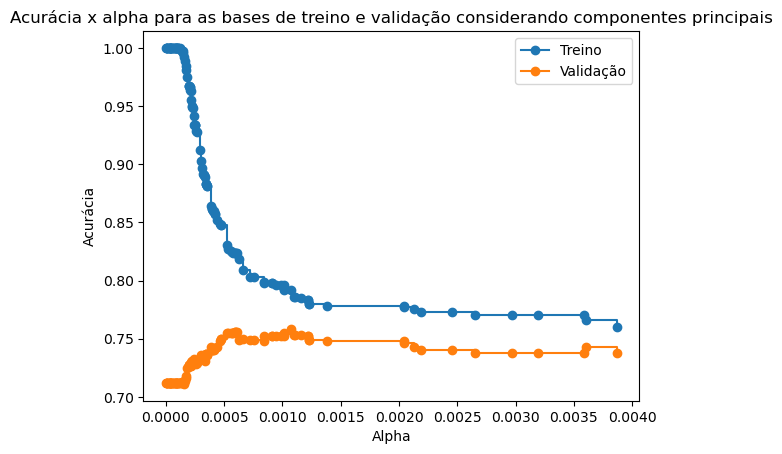

In [29]:
train_score = [clf.score(pc_train, y_train) for clf in clfs]
valid_score = [clf.score(pc_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel('Alpha')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia x alpha para as bases de treino e validação considerando componentes principais')
nx=-10 # Para ignorar os dez últimos elementos (mais distantes)
ax.plot(ccp_alphas[:nx], train_score[:nx], marker='o', label='Treino', drawstyle='steps-post')
ax.plot(ccp_alphas[:nx], valid_score[:nx], marker='o', label='Validação', drawstyle='steps-post')

ax.legend()
plt.show()

In [30]:
len(ccp_alphas), len(ccp_alphas[:nx])

(130, 120)

In [31]:
# Verificando a acurácia
# ind_melhor_arvore = len(valid_score) - valid_score[::-1].index(max(valid_score)) - 1 
ind_melhor_arvore = valid_score.index(max(valid_score))
melhor_arvore = clfs[ind_melhor_arvore]

acc_train = train_score[ind_melhor_arvore]
acc_valid = valid_score[ind_melhor_arvore]
acc_test = melhor_arvore.score(pc_test, y_test)

print('--> A acuáracia da melhor árvore na base de treino foi {:.2f}%'.format(acc_train*100))
print('--> A acuáracia da melhor árvore na base de validação foi {:.2f}%'.format(acc_valid*100))
print('--> A acuáracia da melhor árvore na base de teste foi {:.2f}%'.format(acc_test*100))

melhor_arvore

--> A acuáracia da melhor árvore na base de treino foi 79.18%
--> A acuáracia da melhor árvore na base de validação foi 75.84%
--> A acuáracia da melhor árvore na base de teste foi 73.02%


DecisionTreeClassifier(ccp_alpha=0.00107465007672684, random_state=2360873)

##### Aumentando o número de componentes principais (pcs) 

- n=10

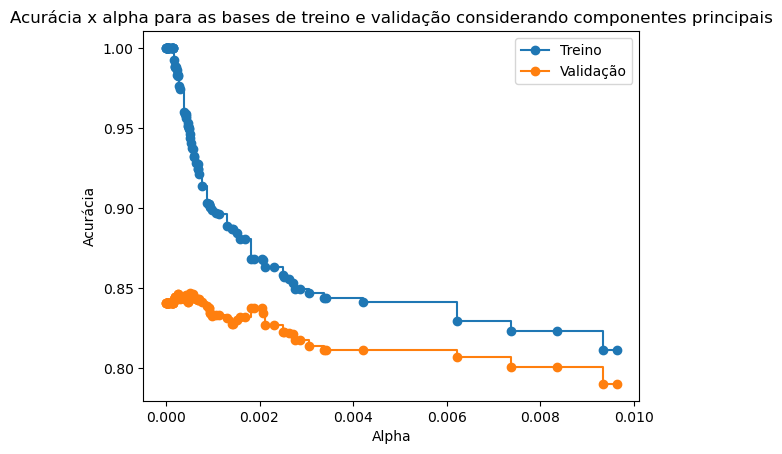

--> A acuáracia da melhor árvore na base de treino foi 94.63%
--> A acuáracia da melhor árvore na base de validação foi 84.71%
--> A acuáracia da melhor árvore na base de teste foi 80.56%
CPU times: total: 8.19 s
Wall time: 8.2 s


DecisionTreeClassifier(ccp_alpha=0.000515455607947446, random_state=2360873)

In [33]:
%%time
n = 10 # Numero de pcs

colunas = ['cp'+str(x+1) for x in list(range(n))]

# [:,:n] Formato para obter os três principais para cada coluna, uma vez que cada elemento to array é composto por uma linha
pc_train = pd.DataFrame(pc_treino[:,:n], columns=colunas) 
pc_valid = pd.DataFrame(pc_valida[:,:n], columns=colunas)
pc_test = pd.DataFrame(pc_teste[:,:n], columns=colunas)

# Gerando as árvores para as componentes principais
path = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

# Plot
train_score = [clf.score(pc_train, y_train) for clf in clfs]
valid_score = [clf.score(pc_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel('Alpha')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia x alpha para as bases de treino e validação considerando componentes principais')
nx=-10 # Para ignorar os dez últimos elementos (mais distantes)
ax.plot(ccp_alphas[:nx], train_score[:nx], marker='o', label='Treino', drawstyle='steps-post')
ax.plot(ccp_alphas[:nx], valid_score[:nx], marker='o', label='Validação', drawstyle='steps-post')

ax.legend()
plt.show()

# Verificando a acurácia
# ind_melhor_arvore = len(valid_score) - valid_score[::-1].index(max(valid_score)) - 1 
ind_melhor_arvore = valid_score.index(max(valid_score))
melhor_arvore = clfs[ind_melhor_arvore]

acc_train = train_score[ind_melhor_arvore]
acc_valid = valid_score[ind_melhor_arvore]
acc_test = melhor_arvore.score(pc_test, y_test)

print('--> A acuáracia da melhor árvore na base de treino foi {:.2f}%'.format(acc_train*100))
print('--> A acuáracia da melhor árvore na base de validação foi {:.2f}%'.format(acc_valid*100))
print('--> A acuáracia da melhor árvore na base de teste foi {:.2f}%'.format(acc_test*100))

melhor_arvore

##### Aumentando o número de componentes principais (pcs) 
- n = 60

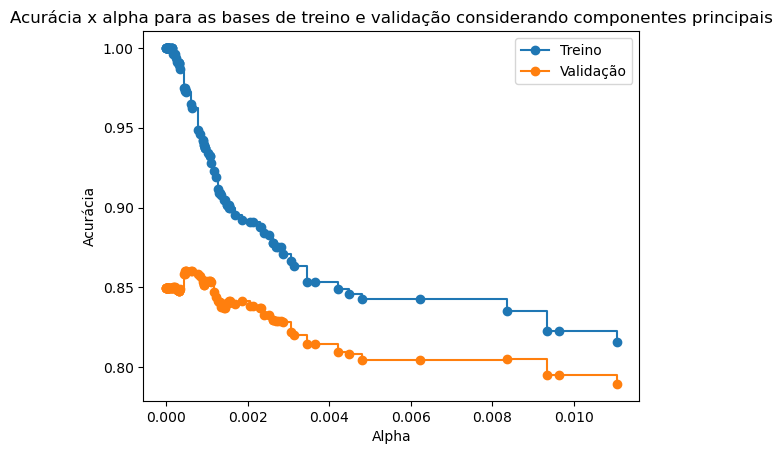

--> A acuáracia da melhor árvore na base de treino foi 97.32%
--> A acuáracia da melhor árvore na base de validação foi 86.02%
--> A acuáracia da melhor árvore na base de teste foi 81.24%
CPU times: total: 51.1 s
Wall time: 51.2 s


DecisionTreeClassifier(ccp_alpha=0.0004721323199716166, random_state=2360873)

In [35]:
%%time
n = 60 # Numero de pcs

colunas = ['cp'+str(x+1) for x in list(range(n))]

# [:,:n] Formato para obter os três principais para cada coluna, uma vez que cada elemento to array é composto por uma linha
pc_train = pd.DataFrame(pc_treino[:,:n], columns=colunas) 
pc_valid = pd.DataFrame(pc_valida[:,:n], columns=colunas)
pc_test = pd.DataFrame(pc_teste[:,:n], columns=colunas)

# Gerando as árvores para as componentes principais
path = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

# Plot
train_score = [clf.score(pc_train, y_train) for clf in clfs]
valid_score = [clf.score(pc_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel('Alpha')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia x alpha para as bases de treino e validação considerando componentes principais')
nx=-10 # Para ignorar os dez últimos elementos (mais distantes)
ax.plot(ccp_alphas[:nx], train_score[:nx], marker='o', label='Treino', drawstyle='steps-post')
ax.plot(ccp_alphas[:nx], valid_score[:nx], marker='o', label='Validação', drawstyle='steps-post')

ax.legend()
plt.show()

# Verificando a acurácia
# ind_melhor_arvore = len(valid_score) - valid_score[::-1].index(max(valid_score)) - 1 
ind_melhor_arvore = valid_score.index(max(valid_score))
melhor_arvore = clfs[ind_melhor_arvore]

acc_train = train_score[ind_melhor_arvore]
acc_valid = valid_score[ind_melhor_arvore]
acc_test = melhor_arvore.score(pc_test, y_test)

print('--> A acuáracia da melhor árvore na base de treino foi {:.2f}%'.format(acc_train*100))
print('--> A acuáracia da melhor árvore na base de validação foi {:.2f}%'.format(acc_valid*100))
print('--> A acuáracia da melhor árvore na base de teste foi {:.2f}%'.format(acc_test*100))

melhor_arvore

##### Aumentando o número de componentes principais (pcs) 
- n = 100

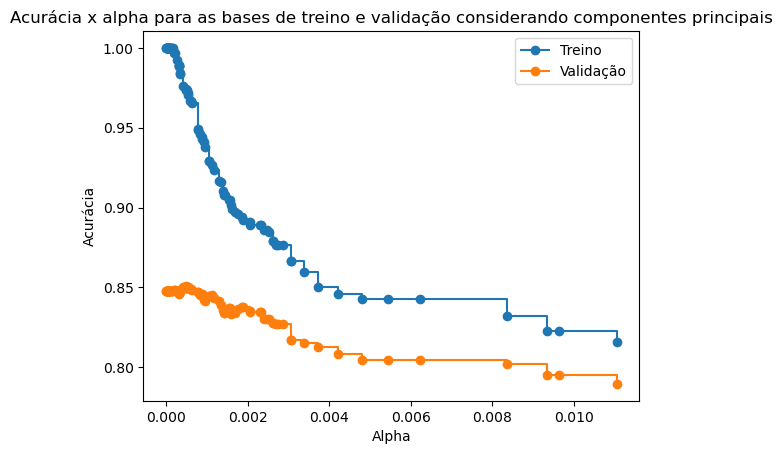

--> A acuáracia da melhor árvore na base de treino foi 97.44%
--> A acuáracia da melhor árvore na base de validação foi 85.09%
--> A acuáracia da melhor árvore na base de teste foi 80.35%
CPU times: total: 1min 20s
Wall time: 1min 20s


DecisionTreeClassifier(ccp_alpha=0.0004791647440117756, random_state=2360873)

In [37]:
%%time
n = 100 # Numero de pcs

colunas = ['cp'+str(x+1) for x in list(range(n))]

# [:,:n] Formato para obter os três principais para cada coluna, uma vez que cada elemento to array é composto por uma linha
pc_train = pd.DataFrame(pc_treino[:,:n], columns=colunas) 
pc_valid = pd.DataFrame(pc_valida[:,:n], columns=colunas)
pc_test = pd.DataFrame(pc_teste[:,:n], columns=colunas)

# Gerando as árvores para as componentes principais
path = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

# Plot
train_score = [clf.score(pc_train, y_train) for clf in clfs]
valid_score = [clf.score(pc_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel('Alpha')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia x alpha para as bases de treino e validação considerando componentes principais')
nx=-10 # Para ignorar os dez últimos elementos (mais distantes)
ax.plot(ccp_alphas[:nx], train_score[:nx], marker='o', label='Treino', drawstyle='steps-post')
ax.plot(ccp_alphas[:nx], valid_score[:nx], marker='o', label='Validação', drawstyle='steps-post')

ax.legend()
plt.show()

# Verificando a acurácia
# ind_melhor_arvore = len(valid_score) - valid_score[::-1].index(max(valid_score)) - 1 
ind_melhor_arvore = valid_score.index(max(valid_score))
melhor_arvore = clfs[ind_melhor_arvore]

acc_train = train_score[ind_melhor_arvore]
acc_valid = valid_score[ind_melhor_arvore]
acc_test = melhor_arvore.score(pc_test, y_test)

print('--> A acuáracia da melhor árvore na base de treino foi {:.2f}%'.format(acc_train*100))
print('--> A acuáracia da melhor árvore na base de validação foi {:.2f}%'.format(acc_valid*100))
print('--> A acuáracia da melhor árvore na base de teste foi {:.2f}%'.format(acc_test*100))

melhor_arvore

## 3 - Matéria prima

- Compreender a importância da covariância e correlação na análise de componentes principais
- Identificar a redundância de informação através da correlação entre variáveis
- Aplicar a padronização para eliminar a escala de variabilidade da variável original

#### Matéria-prima

Podemos discutir muito o que é **informação**. Há teorias sobre isso, pontos de vista, polêmicas etc. Para nós, vamos entender que:

- Os dados trazem informação e
- Informação é variabilidade

Portanto, uma variável que não tenha variabilidade, não tem informação e a informação que os dados trazem está na sua variabilidade.

Dito isto, é importante que tenhamos alguns conceitos básicos muito bem entendidos:

##### Variância

Variância é uma medida de como os dados estão dispersos em torno da média. Pode ser calculada como:

$$ \hat{\sigma}_x^2 = \frac{1}{n-1} \sum_{n=1}^{N} (x_i - \bar{x})^2 $$

A variância de X tem unidade, que é a unidade de X ao quadrado.

##### Desvio padrão

O desvio padrão é a raiz quadrada da variância. Ao se extrair a raiz quadrada, essa medida fica na mesma unidade que a variável original.

$$ \hat{\sigma}_x = \sqrt{\hat{\sigma}_x^2} $$

**Medidas de associação**

As medidas de dispersão indicam como os dados variam em torno de um valor. No entanto, entre duas variáveis X e Y, quando uma delas varia, isso pode dar *informação* sobre o valor da outra variável. Para estudar isto são definidas medidas de associação.

##### Covariância

A covariância procura medir a associação linear entre duas variáveis.

$$ Cov(X, Y) = \sigma_{x,y} = \frac{1}{N} \sum_{i=1}^{N} (X-\bar{X})(Y-\bar{Y}) $$

##### Correlação

A correlação é uma medida de associação adimensional. Ela varia entre -1 e 1, quanto maior em valor absoluto, mais as variáveis "compartilham informação".

$$ Cor(X, Y) = \rho_{x, y} = \frac{Cov(X, Y)}{Var(X)Var(Y)} $$

Uma transformação bem comum é deixar a variável com média = 0 e desvio padrão = 1 com a seguinte transformação:

$$ x_{pad} = \frac{x - \hat{x}}{DesvPad(x)} $$

Um resultado notável - que vale uma ponderação e uma experimentação no notebook - é que a covariância calculada sobre variáveis padronizadas é igual à correlação das variáveis originais (não transformadas). Isso tem algumas consequencias interessantes - pondere um pouco a respeito.

**Notações matriciais**

##### Matriz de covariância

Uma matriz de covariância de um conjunto de variáveis é uma matriz cujas linhas/colunas correspondem às variáveis de interesse, possui na sua diagonal principal a variância da respectiva variável, e fora dela a covariância do respectivo par linha-coluna.

Por simplicidade, podemos denotar $\sigma^2_{1}$ a variância da variável 1, e $\sigma^2_{ij}$ a covariância entre as variáveis i e j (com i $\neq$ j).

$$ \Sigma = \begin{bmatrix}
\sigma^2_{1} & \sigma_{12} & \sigma_{13} \\
\sigma_{21} & \sigma^2_{2} & \sigma_{23} \\
\sigma_{31} & \sigma_{32} & \sigma^2_{3} 
\end{bmatrix}  $$

Observe que como $\sigma_{ij} = \sigma_{ji}$ a matriz será simétrica.

##### Matriz de correlação

Muito similar à matriz de covariâncias, mas possui as correlações. Note que $Cov(x,x) = Var(x)$ mas $Cor(x,x) = 1$ pois a variável sempre está 100% positivamente correlacionada consigo mesma.

$$ R = \begin{bmatrix}
1 & \rho_{12} & \rho_{13} \\
\rho_{21} & 1 & \rho_{23} \\
\rho_{31} & \rho_{32} & 1 
\end{bmatrix}  $$


## 4 - Geometria do PCA

- Compreender a intuição geométrica por trás da análise de componentes principais (PCA)
- Aplicar o conceito de transformação linear em dados
- Identificar a importância dos auto vetores e auto valores na análise de componentes principais

##### Carregando dados 

Para ilustrar vamos utilizar dados (fictícios) de notas de 100 alunos do ensino médio que avaliam 5 matérias através de 4 provas cada uma (p1, p2, p3 e p4) - totalizando 20 provas.

- Os dados que serão carregados estão no formato **feather** -  um formato criado primeiramente para intercambiar dados entre R e Python, e que é bem mais conveniente de ser utilizado para persistir dados do que o CSV na maioria das aplicações.

In [42]:
df = pd.read_feather('notas.ftr')

In [43]:
df.head()

,mat_p1,mat_p2,mat_p3,mat_p4,por_p1,por_p2,por_p3,por_p4,his_p1,his_p2,his_p3,his_p4,geo_p1,geo_p2,geo_p3,geo_p4,art_p1,art_p2,art_p3,art_p4
0,4.00,3.95,5.20,5.10,2.4,5.5,4.8,6.1,4.1,4.6,5.1,4.0,2.2,1.8,2.3,5.4,7.84,8.53,9.14,9.40
1,1.15,1.80,3.45,2.55,3.3,4.6,4.6,4.8,5.7,4.4,6.5,6.9,3.3,3.8,6.2,3.4,8.01,8.50,9.14,9.63
2,6.65,8.15,7.20,8.80,2.8,5.0,3.1,7.2,5.4,7.2,8.1,8.0,10.0,8.2,10.0,10.0,9.61,9.82,10.00,10.00
3,5.90,6.25,7.00,7.60,4.7,3.7,6.1,4.7,5.0,5.8,6.3,5.6,6.2,7.2,8.3,7.9,9.48,10.00,10.00,10.00
4,7.30,7.90,7.45,10.00,7.5,7.3,7.7,10.0,5.8,7.7,8.2,8.7,10.0,10.0,10.0,10.0,9.55,9.95,10.00,10.00


##### Ilustração em 2D

Vamos começar a ilustração da ideia por trás das componentes principais avaliando primeiramente apenas duas matérias, de modo que podemos fazer a visualização geométrica em 2D.

Lembre-se que para nós variabilidade é informação, portanto, variabilidade compartilhada (correlação) é redundância de informação entre duas variáveis. Vamos então selecionar duas variáveis correlacionadas e começar a pensar um pouco sobre esses conceitos de informação e redundância.

In [45]:
vars = ['por_p1', 'por_p2']

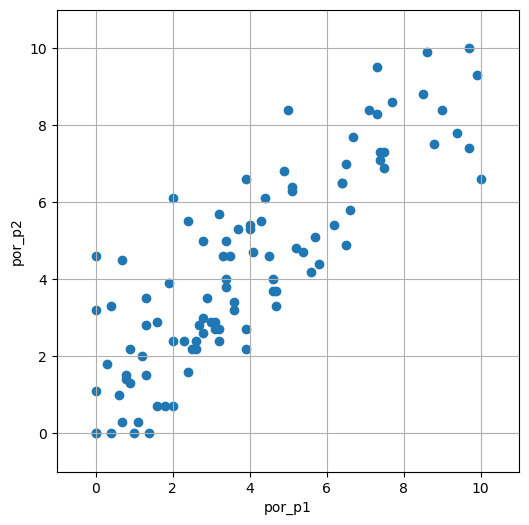

In [46]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)

ax.set_aspect('equal', 'box')
ax.set(xlim=[-1,11], ylim=[-1,11])

plt.scatter(x=df[vars[0]], y=df[vars[1]])
ax.set_xlabel('por_p1')
ax.set_ylabel('por_p2')
ax.grid()

plt.show()

In [47]:
df[vars].corr()

,por_p1,por_p2
por_p1,1.00000,0.85389
por_p2,0.85389,1.00000


In [48]:
# Avaliando a correlação ao quadrado, ou seja, o R-quadrado

df[vars].corr()**2

,por_p1,por_p2
por_p1,1.000000,0.729128
por_p2,0.729128,1.000000


As duas variáveis compartilham 73% da informação, ou seja, é o que elas têm de redundância.

In [50]:
# A matriz de covariância

df[vars].cov()

,por_p1,por_p2
por_p1,7.230202,5.925505
por_p2,5.925505,6.660342


**Na diagonal principal temos a variância da p1 e da p2 e na diagonal secundária a covariância.**

##### Transformações lineares

Pode ser útil fazer alguma transformação linear nesses dados? Por exemplo, média e diferença entre as notas? Que características essa transformação possui?

Text(0, 0.5, 'por_p2 (azul) & evolução p1 $\\rightarrow$ p2 (laranja)')

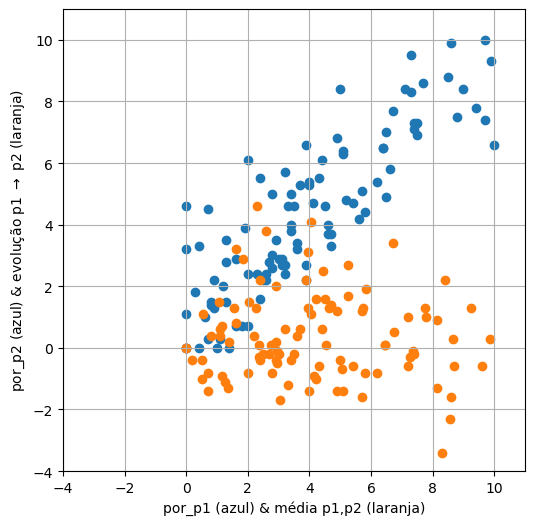

In [53]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)

ax.set_aspect('equal', 'box')
ax.set(xlim=[-4, 11], ylim=[-4, 11])

plt.scatter(x=df[vars[0]], y=df[vars[1]])

# A matriz de transformação
m = np.array([[.5,.5],
             [-1, 1]])
# Matriz dos dados das notas (ajuste do dimensionamento)
m_notas = m_notas = df[vars].transpose().to_numpy()

# Aplicando a matriz
df_rot = np.matmul(m, m_notas)
plt.scatter(df_rot[0,:], df_rot[1,:])
ax.grid()
ax.set_xlabel('por_p1 (azul) & média p1,p2 (laranja)')
ax.set_ylabel(r'por_p2 (azul) & evolução p1 $\rightarrow$ p2 (laranja)')

In [54]:
# Verificando
m_notas = df[vars].transpose().to_numpy()
m_notas[0,:]

array([ 2.4,  3.3,  2.8,  4.7,  7.5,  3.2,  1.8,  0.7,  0. ,  3.5,  2.8,
        3.4,  0.8,  0.4,  1.9,  3.7,  6.7,  1.3,  1.6,  1.1,  3.6,  9.9,
        3.1,  0.4,  3.6,  5.4,  3.4,  7.4,  0.8,  1.6,  2.6,  3. ,  1. ,
        2. ,  8.8,  1.2,  3.1,  7.7,  9. ,  5.7,  8.5,  0. ,  2.7,  0.3,
        7.3,  4.6,  5.1,  4. , 10. ,  7.4,  2.9,  6.6,  5.2,  0. ,  0. ,
        4.6,  2.8,  2.5,  6.4,  1.4,  3.4,  4.5,  0.6,  4.9,  4. ,  3.9,
        6.2,  3.2,  2.3,  4.4,  9.7,  1.3,  0. ,  4.3,  8.6,  4.7,  2.4,
        4.1,  7.5,  5.8,  5. ,  7.3,  6.4,  0.7,  1.3,  2.6,  7.1,  6.5,
        6.5,  5.1,  9.4,  2. ,  3.2,  0.9,  2. ,  5.6,  3.9,  9.7,  0.9,
        3.9])

In [55]:
# Avaliando a correlação dos dados transformados
pd.DataFrame(df_rot.transpose()).corr()

,0,1
0,1.000000,-0.078648
1,-0.078648,1.000000


Uma vez que a correlação é muito mais baixa no dados transformados, se comparado aos dados originais, indicando que os dados possuem menos redundância.

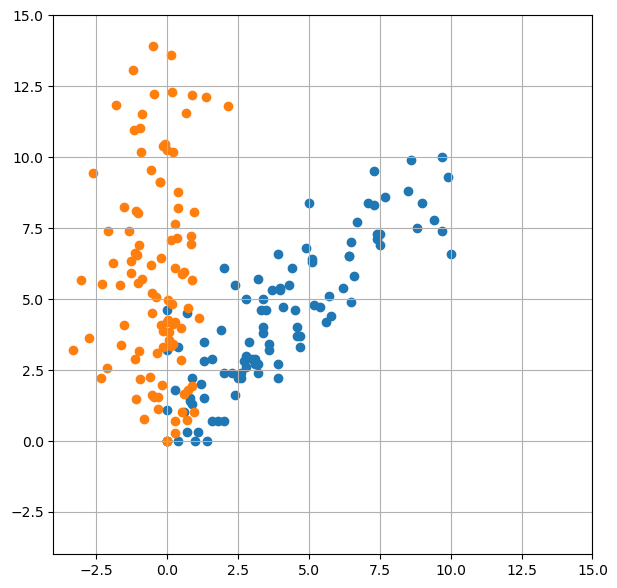

In [57]:
# Uma nova transformação linear

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)

ax.set_aspect('equal', 'box')
ax.set(xlim=[-4, 15], ylim=[-4, 15])

m2 = np.array([[ 0.69245036, -0.72146552],
              [ 0.72146552,  0.69245036]])

df_rot = np.matmul(m2, df[vars].to_numpy().transpose())

#plot
plt.scatter(df[vars[0]], df[vars[1]])
plt.scatter(df_rot[0,:], df_rot[1,:]) # rotaciona e mantém o eixo de maior variavilidade como sendo o y
# O gráfico é mantido em suas proporções e apenas rotaciona 
ax.grid()

In [58]:
m2 = np.array([[ 0.69245036, -0.72146552],
              [ 0.72146552,  0.69245036]])
print(m2[0][0])
print(m2[1][0])

print(m2[0][0]**2 + m2[1][0]**2)

0.69245036
0.72146552
0.9999999976130001


**Na análise acima temos o valor igual a 1 ou muito próximo disso, ou seja, os vetores usados são unitários. Dessa forma, o gráfico mantém sua proporcionalidade e é apenas rotacionado, facilitando a seleção do eixo que fornece mais informação.**

In [60]:
pd.DataFrame(df_rot.transpose()).corr()

,0,1
0,1.000000,0.011516
1,0.011516,1.000000


Ao transformar os dados, podemos notar que os dados agora estão menos correlacionados.

##### Scatterplot 2D com autovetores

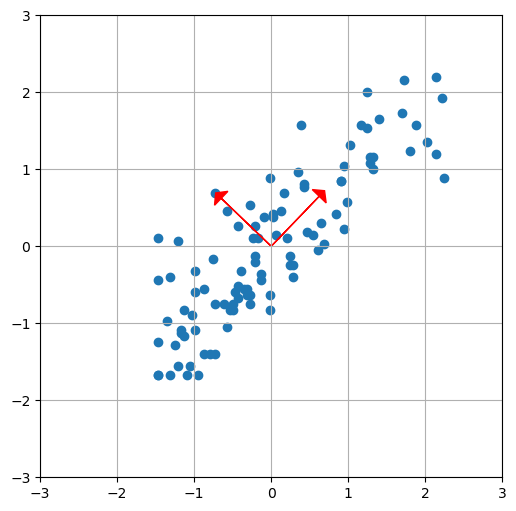

In [63]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)

X = df[vars].apply(lambda var: (var - var.mean())/var.std(), axis=0)

ax.scatter(x = X.iloc[:,0], y=X.iloc[:,1])
ax.grid()

xmin = -3
xmax = 3
ymin = -3
ymax = 3

ax.set_aspect('equal', 'box')
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

autovet = np.array([[ 0.69245036, -0.72146552],
                    [ 0.72146552,  0.69245036]])

ax.arrow(0,0,autovet[0,0], autovet[1,0],
        head_width=.25,
        head_length=.1,
        fc='r', ec='r',
        length_includes_head=True)

ax.arrow(0,0,autovet[0,1], autovet[1,1],
        head_width=.25,
        head_length=.1,
        fc='r', ec='r',
        length_includes_head=True)

*Decomposição matricial em autovalores e autovetores.*
- O autovalor associado a um determinado autovetor é a variabilidade dos dados ao longo do eixo do autovetor.

## 5 - Informação

- Compreensão da função PCA e os atributos do objeto gerado
- Aplicação da transformação linear para gerar componentes principais
- Interpretação da variância explicada na análise de componentes principais

##### Explorando PCA do Scikitlearn

Vamos analisar onde ficam guardados os autovalores e autovetores e explorar outros atributos interessantes.

In [67]:
df = pd.read_feather('notas.ftr')

In [68]:
# Considerando apenas dois valores
vars = ['por_p1', 'por_p2']

In [69]:
df[vars].head()

,por_p1,por_p2
0,2.4,5.5
1,3.3,4.6
2,2.8,5.0
3,4.7,3.7
4,7.5,7.3


In [70]:
pca = PCA() # Definindo o modelo
princomp = pca.fit(df[vars]) # Aplicando o fit

# Aplicando a transformação linear (transform) para gerar as componentes principais
componentes = princomp.transform(df[vars])

principal = pd.DataFrame(data=componentes, columns=['CP1', 'CP2'])

In [71]:
principal

,CP1,CP2
0,-0.307236,1.924284
1,-0.276661,0.651859
2,-0.362639,1.286372
3,0.115858,-0.965525
4,4.626447,-0.291292
...,...,...
95,1.112316,-1.224505
96,-1.153170,-1.137480
97,6.287994,-1.736720
98,-3.669794,0.570326


**Vamos explorar os seguintes elementos:**
- Autovetores
- Autovalores
- Variância e covariância das CPSs
- Variância das variáveis originais
- Variância explicada

In [73]:
# Obtendo a matriz de autovetores
princomp.components_

array([[ 0.72388874,  0.68991673],
       [-0.68991673,  0.72388874]])

In [74]:
# Os autovalores associados aos autovetores são:
princomp.explained_variance_

# Vale destacar que o autovalor é a variância do autovetor

array([12.87762379,  1.01292066])

O primeiro autovalor explica 12.87 da variância enquanto o segundo explica 1%

In [76]:
# A proporção explicada pelas componentes principais é dada por

print(princomp.explained_variance_ratio_)

# Outra forma de calcular
princomp.explained_variance_ / princomp.explained_variance_.sum()

[0.9270784 0.0729216]


array([0.9270784, 0.0729216])

A primeira **componente principal** explica  ~93% da variância dos dados e a segunda ~7.3%.

In [78]:
princomp.explained_variance_.sum()

13.890544444444469

In [79]:
# Analisando a covariância
print(princomp.explained_variance_)

# A covariância
principal.cov()

[12.87762379  1.01292066]


,CP1,CP2
CP1,1.287762e+01,-4.458835e-15
CP2,-4.458835e-15,1.012921e+00


Interessante notar que a variância (diagonal principal) é dada pelos autovalores e a covariância (diagonal secundária) é algo praticamente zero, provavelmente não o é devido aos pontos flutuantes.

In [81]:
# Vamos olhar agora para a variância e a covariância no dados originais
df[vars].cov()

,por_p1,por_p2
por_p1,7.230202,5.925505
por_p2,5.925505,6.660342


A covariância, principalmente, é muito alta se comparada aos dados transformados pelo PCA. Interessante notar que a soma da componente principal resulta na soma dos autovalores

In [83]:
# Diagonal principal
print(7.230202 + 6.660342) # Variabilidade total dos dados

princomp.explained_variance_.sum() # Variabilidade das componentes principais

13.890544


13.890544444444469

Ou seja, é correto afirma que as componentes principais trazem, como esperado, as mesmas informações que dos dados originais.

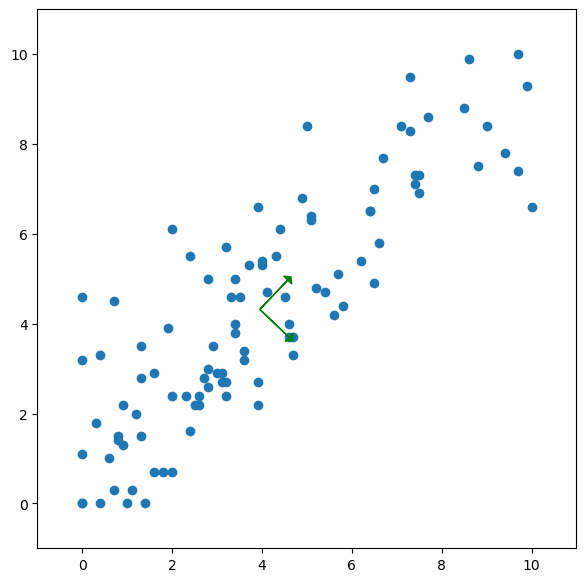

In [85]:
%matplotlib inline

X = df[vars]

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)

x_med = X.iloc[:,0].mean()
y_med = X.iloc[:,1].mean()

ax.scatter(x= X.iloc[:,0], y=X.iloc[:,1])

ampli_x = X.iloc[:,0].max() - X.iloc[:,0].min()
ampli_y = X.iloc[:,1].max() - X.iloc[:,1].min()

xmin = X.iloc[:,0].min() - ampli_x*.1
xmax = X.iloc[:,0].max() + ampli_x*.1
ymin = X.iloc[:,1].min() - ampli_y*.1
ymax = X.iloc[:,1].max() + ampli_y*.1

ax.set_aspect('equal', 'box')
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax));

autovet = princomp.components_

ax.arrow(x_med, y_med, autovet[0,0], autovet[1,0],
        head_width = .25,
        head_length = .1,
        fc='g', ec='g',
        length_includes_head=True)
ax.arrow(x_med, y_med, autovet[0,1], autovet[1,1],
        head_width = .25,
        head_length = .1,
        fc='g', ec='g',
        length_includes_head=True)

plt.show()

In [86]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

variaveis = ['mat_p1', 'mat_p2', 'mat_p3']

pca = PCA()
princomp = pca.fit_transform(df[variaveis])
autovet=pca.components_
autoval = pca.explained_variance_

ax.scatter( df[variaveis[0]], df[variaveis[1]], df[variaveis[2]] )

for i, v in enumerate(autovet):
    ax.plot([df[variaveis[0]].mean(), df[variaveis[0]].mean()+v[0]*autoval[i]**.5], 
            [df[variaveis[1]].mean(), df[variaveis[1]].mean()+v[1]*autoval[i]**.5], 
            [df[variaveis[2]].mean(), df[variaveis[2]].mean()+v[2]*autoval[i]**.5], 
            color='red', 
            alpha=0.8, 
            lw=3)

<IPython.core.display.Javascript object>

A matriz de correlação

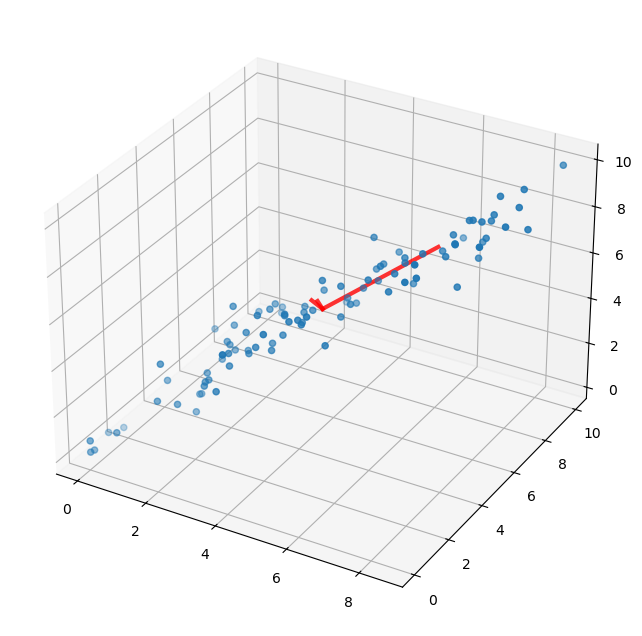

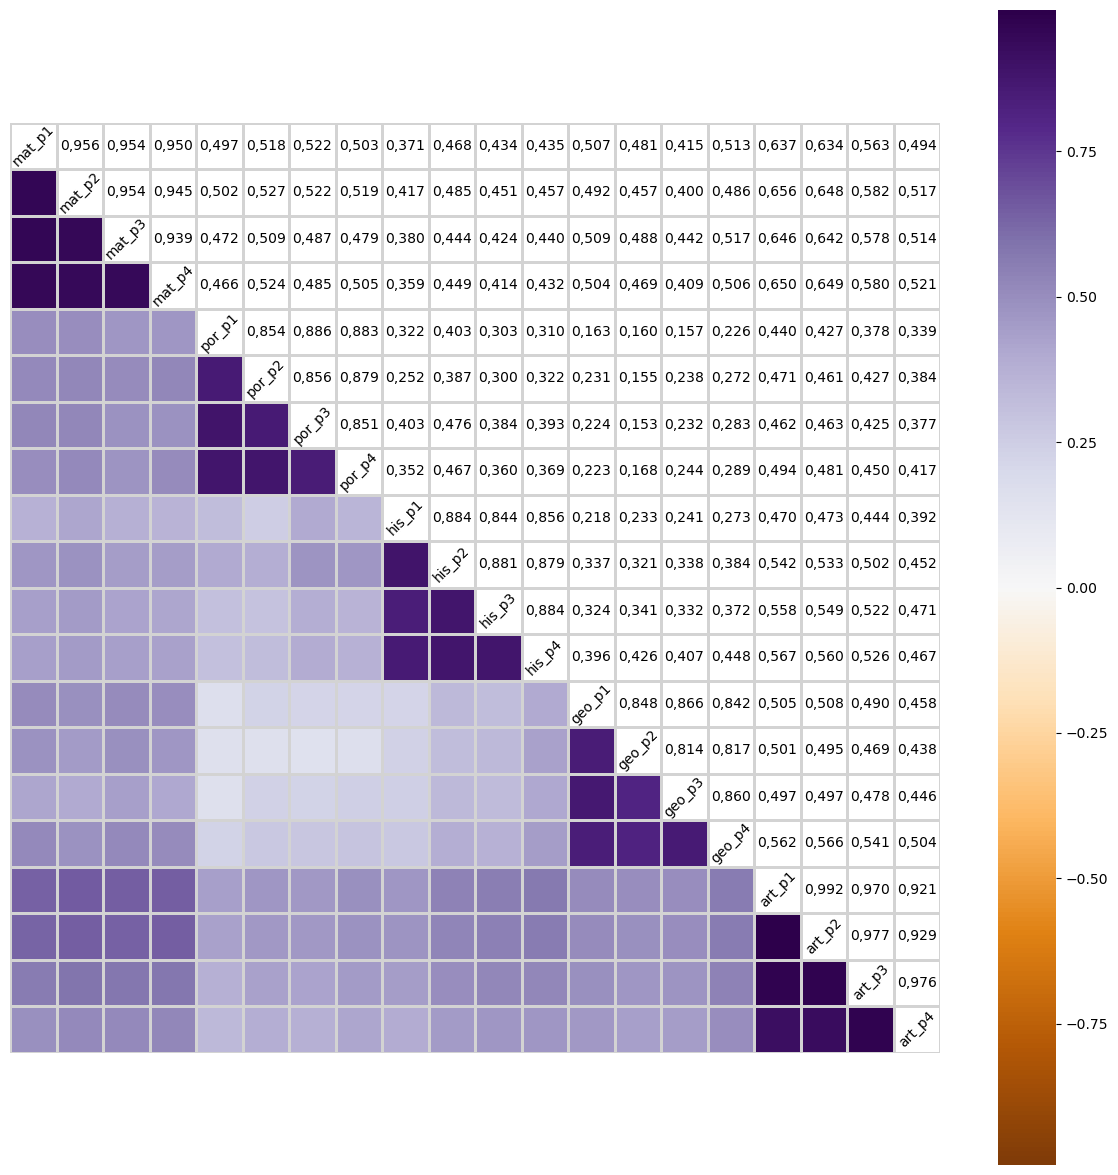

In [88]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 15))

# calcula a matriz de correlação
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True


# Draw the heatmap with the mask and correct aspect ratio
vmax = np.abs(corr.values[~mask]).max()
sns.heatmap(corr, mask=mask, cmap=plt.cm.PuOr, vmin=-vmax, vmax=vmax,
            square=True, linecolor="lightgray", linewidths=1, ax=ax);
for i in range(len(corr)):
    # Coloca o texto na diagonal principal
    ax.text(i+0.5,(i+0.5), corr.columns[i], 
            ha="center", va="center", rotation=45)
    for j in range(i+1, len(corr)):
        s = "{:.3f}".format(corr.values[i,j]).replace(".",",")
        ax.text(j+0.5,(i+0.5),s, 
            ha="center", va="center")
        
ax.axis("off")
plt.show()

In [89]:
# Analise de componentes principais (PCA)

pca = PCA()

n_componentes = df.shape[1]

princomp = pca.fit(df)

componentes = princomp.transform(df)

nomes_pca = ['CP'+str(x+1) for x in list(range(n_componentes))]

#DataFrame
principalDF = pd.DataFrame(data=componentes, columns=nomes_pca)

In [90]:
principalDF.head()

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,CP11,CP12,CP13,CP14,CP15,CP16,CP17,CP18,CP19,CP20
0,-4.610732,4.690160,-0.331307,2.192519,1.088823,-1.534730,-0.298403,0.303581,0.958679,0.595188,-0.824093,-0.031911,0.445961,1.740720,-0.866548,-0.714433,0.115392,0.112390,-0.106757,0.027418
1,-5.041637,2.196658,2.771041,-2.621770,0.431806,-0.379825,-0.421596,-0.835760,-0.900185,-1.219166,2.214314,0.209083,-0.563257,-0.039784,-0.172352,-0.631430,-0.148592,0.309210,0.044014,-0.026102
2,6.918780,-5.942832,-2.514650,0.665987,1.269202,-1.636873,-1.870399,1.597834,-0.499486,1.053132,0.115407,0.305039,-0.516435,0.062983,0.027907,1.079217,-0.019474,-0.076259,0.085275,0.064387
3,2.973611,-1.917624,-2.741752,1.026047,-0.376004,0.423874,1.516583,-0.402015,0.255381,0.623925,1.099386,-0.452860,0.752388,-0.442430,0.574530,-0.004740,-0.299427,-0.134185,-0.046691,-0.003177
4,12.120859,-1.581032,-3.816082,-1.725571,-0.495450,0.119050,-1.706732,0.820147,-0.402935,0.899057,0.016262,0.873351,-0.015455,-0.234104,1.091864,0.492440,-0.101687,0.009224,-0.028129,0.039910


In [91]:
princomp.components_
# retorna a matriz 20x20

array([[ 2.57121066e-01,  2.53290536e-01,  2.56913143e-01,
         2.62157732e-01,  2.63768010e-01,  2.58618621e-01,
         2.90151269e-01,  2.73788343e-01,  2.29279567e-01,
         2.51692025e-01,  2.49259466e-01,  2.46109715e-01,
         2.12853254e-01,  2.00927464e-01,  1.92107353e-01,
         2.10034059e-01,  1.10027418e-01,  1.06088540e-01,
         8.36604833e-02,  6.09967366e-02],
       [-3.10474101e-02, -2.08736984e-02, -4.71789955e-02,
        -3.63103773e-02,  3.87403493e-01,  3.40078810e-01,
         3.61860943e-01,  3.43210854e-01, -3.89860974e-02,
        -3.59408594e-02, -9.26765431e-02, -1.17738414e-01,
        -3.52322678e-01, -3.71548146e-01, -3.20251798e-01,
        -2.94943748e-01, -3.23947391e-02, -3.31247832e-02,
        -2.97475168e-02, -2.36030718e-02],
       [-1.55407041e-01, -1.28494263e-01, -1.58546349e-01,
        -1.66178640e-01, -1.09222005e-01, -1.50176271e-01,
        -5.99494085e-02, -8.68452187e-02,  4.84414148e-01,
         3.90850458e-01,  4.3

In [92]:
princomp.explained_variance_ratio_

# Porcentagens de explicação da variabilidade dos dados

array([5.16917090e-01, 1.75110766e-01, 1.33341891e-01, 7.64485992e-02,
       1.59413412e-02, 1.34222543e-02, 1.22564369e-02, 1.03016488e-02,
       8.58245993e-03, 7.99906659e-03, 6.91925410e-03, 5.62140262e-03,
       5.15829214e-03, 4.78720378e-03, 2.83443537e-03, 2.00157426e-03,
       1.75622294e-03, 4.84229858e-04, 6.85419290e-05, 4.72897327e-05])

In [93]:
# Usando soma acumulada
princomp.explained_variance_ratio_.cumsum()

# Interpretação: com uma componente consigo explicar 51.69% dos dados, com as 3 primeiras 82.54%, ... 
# com todas as componentes 100% dos dados
# Aqui já podemos filtrar quais variáveis utilizar e o quanto a adição de uma nova componente irá influenciar/melhorar.

array([0.51691709, 0.69202786, 0.82536975, 0.90181835, 0.91775969,
       0.93118194, 0.94343838, 0.95374003, 0.96232249, 0.97032155,
       0.97724081, 0.98286221, 0.9880205 , 0.99280771, 0.99564214,
       0.99764372, 0.99939994, 0.99988417, 0.99995271, 1.        ])

## 6 - Explicação da variância

- Compreender os conceitos de autovetores e autovalores da matriz de variância
- Analisar as propriedades das componentes principais e sua aplicação na redução de dimensionalidade
- Avaliar critérios para decidir o número de componentes principais a serem utilizados.

##### Autovetores e autovalores

É uma técnica de Algebra Linear que fornece pares de vetores e escalares chamados de autovetores e autovalores, que possuem propriedades muito interessantes, e podem ser obtidos através de uma equação matricial.

Em Componentes Principais, a matriz utilizada no algoritmo é tipicamente uma dentre duas opções:

- Matriz de variância: utilizada quando é importante manter a escala original das variáveis
- Matriz de correlação: utilizada quando as variáveis possuem escalas diferentes, e podem receber pesos (no sentido de importância) diferentes de forma arbitrária por conta dessas escalas.

**Autovetores**
Os autovetores fornecem as direções de maior variabilidade dos dados - o que pode ser visto em 2 (ou até 3) dimensões, mas funciona igualmente com uma quantidade de dimensões (isto é, com um número arbitrário de variáveis).

**Autovalores**
Os autovalores indicam a variabilidade na direção dos respectivos autovetores. Na prática, eles fornecem a variância das componentes principais.

**Componentes principais**
São as projeções dos dados originais nos autovetores. São novas variáveis, obtidas como combinações lineares das variáveis originais, e possuem propriedades muito interessantes:

- Se considerarmos todas as componentes, agregam a mesma informação que os dados originais
- Possuem correlação linear zero entre sí. Isso significa que não compartilham informação (ao menos do ponto de vista linear).
- Podem ser ordenadas conforme a explicação da variabilidade das variáveis originais.
- Dessa forma, se temos *p* variáveis, podemos considerar *q<p* componentes principais que vão explicar mais variabilidade (i.e. informação) que quaisquer outras *q* variáveis originais.

##### Quantas componentes principais utilizar?

O número de componentes que o algoritmo dá, conceitualmente, é igual ao númeor de variáveis originais. No entanto, pelas propriedades da técnica, podemos utilizar apenas um número arbitrário das componentes iniciais (aquelas que mais explicam variância) e ignorar as demais.

Mas quantas componentes vamos utilizar?

Claro que há uma carga de subjetividade grande nesta pergunta, e não há uma única resposta correta, mas há potencialmente uma quantidade grande de respostas úteis para cada problema. E para guiar esse tipo de decisão, vamos falar de 4 critérios bastante utilizados na literatura.


1. Autovalor maior que 1: Este critério funciona com as variáveis padronizadas para que tenham todas variância > 1 - o autovalor é a variância da componente principal, escolhendo componentes com autovalor>1 você estará selecionando somente autovalores que explicam mais informação que uma variável original.
2. Variância explicada > x: Somando a variância explicada você pode estabelecer um valor mínimo exigido, por exemplo 90%, e selecionar o número de componentes que explica 90% da variância total.
3. Gráfico do cotovelo (screeplot): Ao observar o gráfico da variância explicada por cada componente, buscamos um 'cotovelo' e ignoramos as variáveis que explicam muito pouco da variância total.
4. Utilizar um número pragmático: este critério pode ser utilizado por exemplo se temos alguma limitação - por exemplo, se você sabe que o seu hardware vai tolerar 100 variáveis, você usa pragmaticamente esse valor.

##### Gráfico simples

Gráficos para auxiliar na seleção do número de componentes principais. Todos eles giram tem como base a variância explicada. Vamos avaliar a variância explicada total e o percentual da variância explicada - o desenho do gráfico tem sempre a mesma cara, mudando apenas a escala.

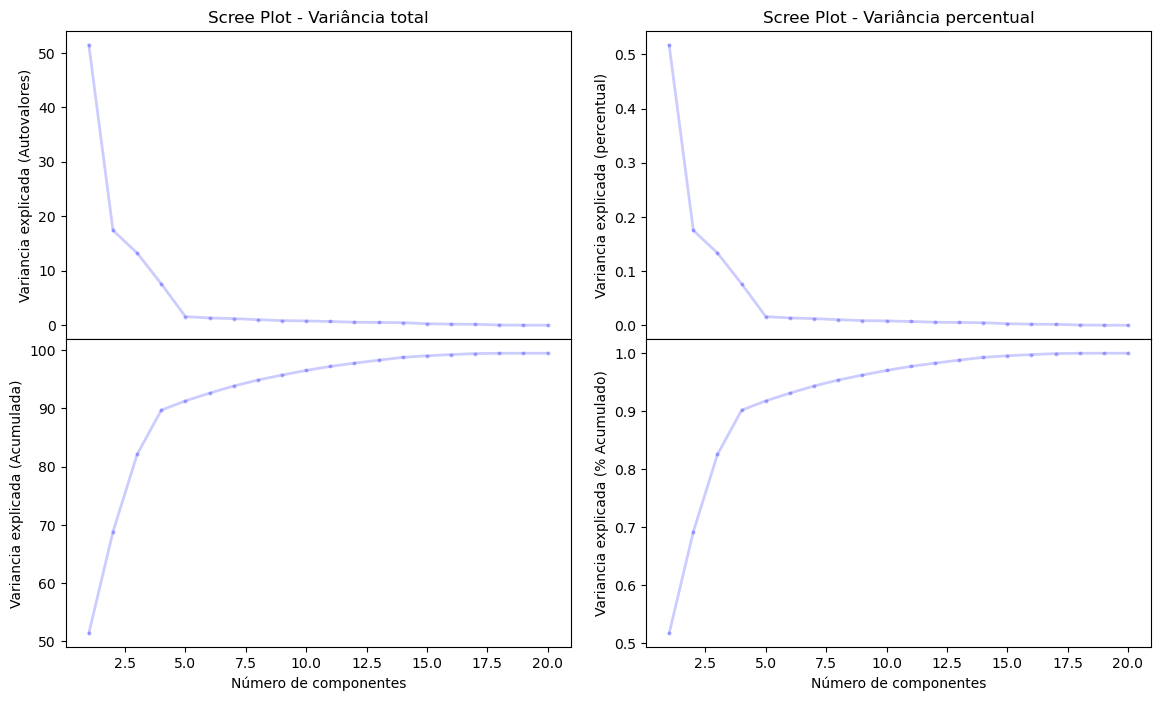

In [171]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

ampli_y1 = princomp.explained_variance_[0]

num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


ampli_y2 = princomp.explained_variance_ratio_[0]
# ax[1].set_ylim(-ampli_y2*.05, ampli_y2*1.1)

ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')


plt.show()

#### Critério 1 - autovalor > 1

Este critério funciona melhor com as variáveis padronizadas para que tenham todas variância=1. O autovalor é a variância da componente principal, escolhendo componentes com autovalor>1 você estará selecionando somente autovalores que explicam mais informação que uma variável original. Quando as variáveis não são padronizadas, podemos utilizar a variância explicada percentual maior que 1/<número de variáveis> - mas isso não garante que as componentes expliquem mais variabilidade que qualquer outra variável.

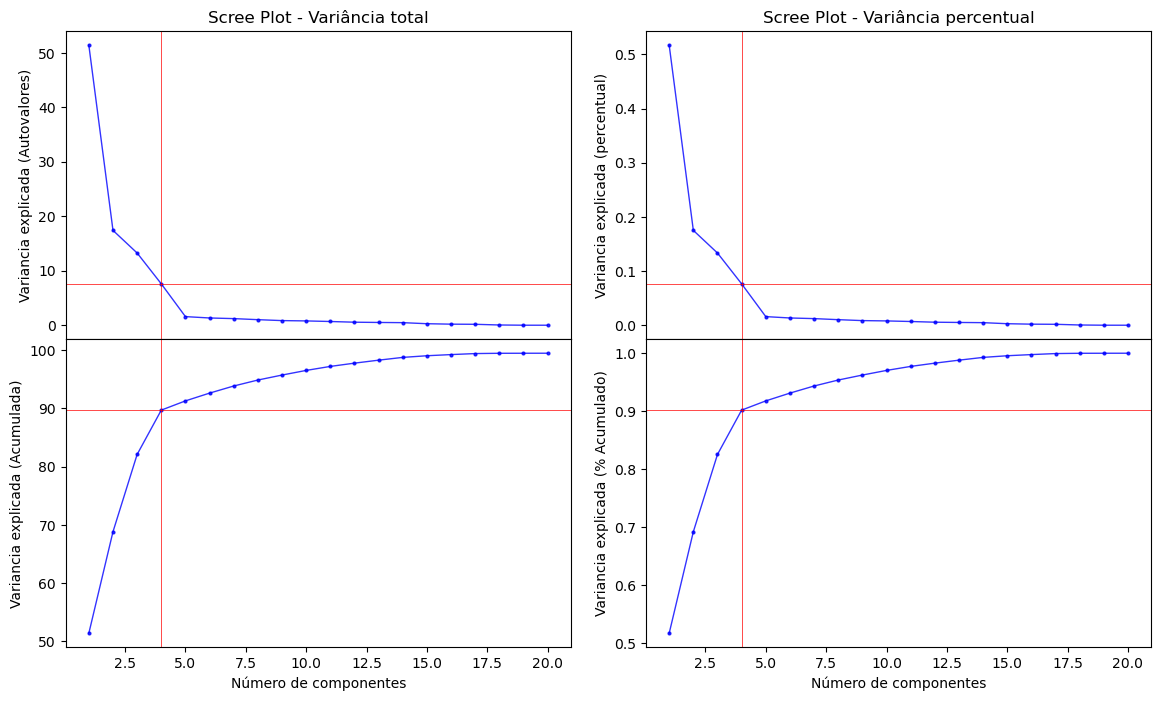

In [180]:
# Critério 1: autovalor padronizado > 1
ncomp_criterio1 = (princomp.explained_variance_ratio_>1 / princomp.n_components_).sum()

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd_componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

# Gráfico da variância percentual por qtd_componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

# Gráfico da variância percentual acumulada por qtd_componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)


# linhas horizontais
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

- Utilizar variáveis que possuírem variabilidade percentual maior do que 5% (primeiro gráfico da coluna da direita - para esse caso se utiliza 4 componentes principais)
- Para esse caso, com 4 componentes principais somos capazes de explicar pouco menos de 90 pontos da variabilidade dos dados e pouco mais de 90% da variabilidade total dos dados, informação dos dados (segunda linha de painéis)

#### Critério 2 - *screeplot* ou critério do cotovelo (subjetivo?!)

Gráfico do cotovelo (screeplot): Ao observar o gráfico da variância explicada por cada componente, buscamos um 'cotovelo' e ignoramos as variáveis que explicam muito pouco da variância total

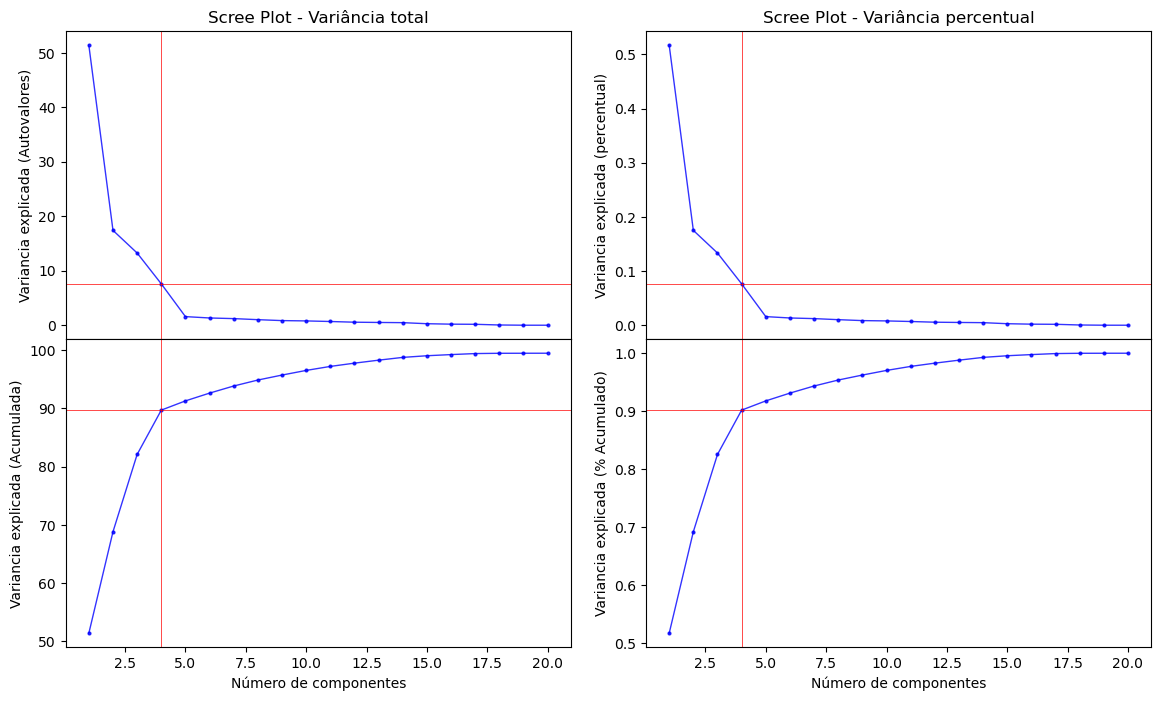

In [190]:
# Critério 2: Método do "cotovelo"
ncomp_criterio2 = 4

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Número de componentes pelo critério 2
ax[0,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

- (Primeira linha de painéis) - É selecionada a componente imediatamente anterior ao ponto em que há um "cotovelo" ou a partir da qual é necessário um grande número de componentes para se explicar pouca variabilidade dos dados.

In [201]:
princomp.explained_variance_ratio_.cumsum()

array([0.51691709, 0.69202786, 0.82536975, 0.90181835, 0.91775969,
       0.93118194, 0.94343838, 0.95374003, 0.96232249, 0.97032155,
       0.97724081, 0.98286221, 0.9880205 , 0.99280771, 0.99564214,
       0.99764372, 0.99939994, 0.99988417, 0.99995271, 1.        ])

#### Critéiro 3: Variância explicada > x

Variância explicada > x: Somando a variância explicada você pode estabelecer um valor mínimo exigido, por exemplo 90%, e selecionar o número de componentes que explica 90% da variância total.

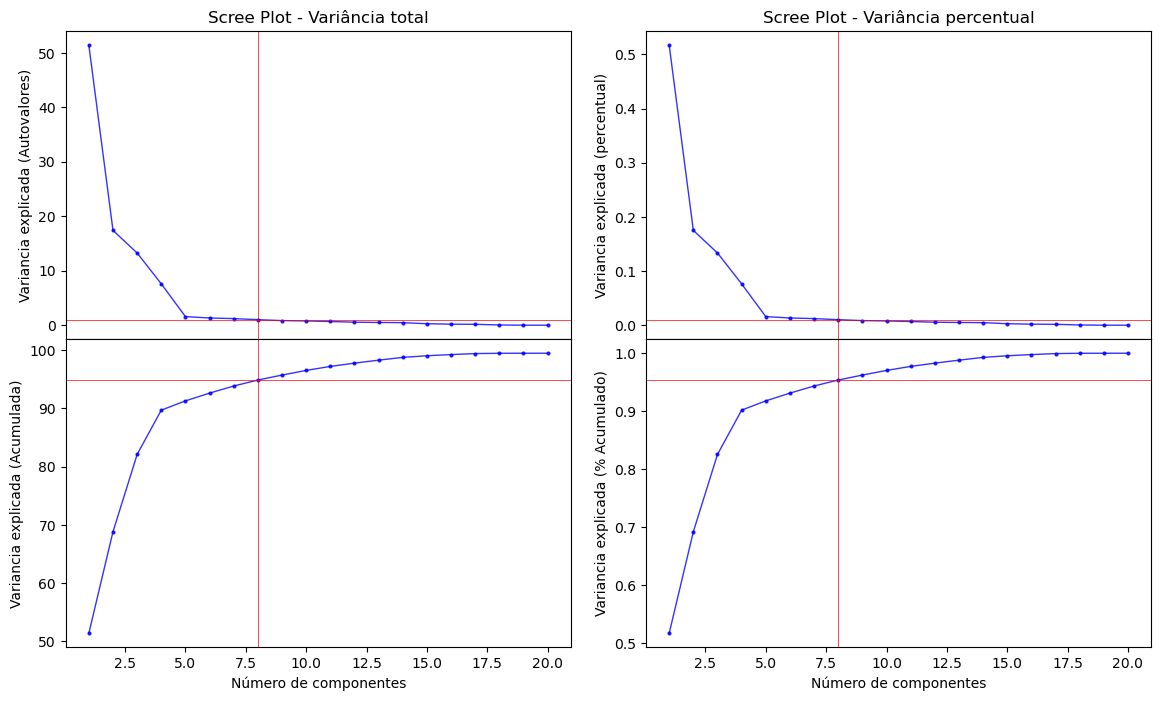

In [205]:
# Critério 3: % variância explicada

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério 3
varexplicada = .95
ncomp_criterio3 = (princomp.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1 
# Retorna o número de variáveis que explicam menos de 95%, soma-se mais um para ultrapassar esse valor
# Ou seja, o número de componenetes para explicar, pelo menos, 95% dos dados


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.8)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ncomp_criterio2 = 50
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

## 7 - Quantas componentes?

- Compreender o uso do PCA para redução de dimensionalidade dos dados
- Aplicar o algoritmo de floresta aleatória para treinar um modelo de reconhecimento de dígitos
- Analisar a correlação entre os componentes principais e os pixels originais.

#### Reconhecimento de escrita manual

##### Carregando os dados

Há duas opções para carregar os dados: 
1. carregar do pacote Keras
2. Carregar do website

In [229]:
# !pip install keras
# !pip install tensorflow
# !pip install mnist

In [301]:
from keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

In [299]:
# %%time

# import mnist

# X_train = mnist.train_images()
# y_train = mnist.train_labels()

# X_test = mnist.test_images()
# y_test = mnist.test_labels()

In [307]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [309]:
# Salvando os dados para necessidades futuras

# Persistir os dados no formato numpy
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)

np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [311]:
# Ler os dados no formato numpy
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

##### Análise exploratória

Entendendo como estão os dados e avaliando se um determinado pixel tende a estar ou não preenchido para cada número.

In [316]:
pd.set_option('display.max_columns', None)

In [320]:
pd.DataFrame(X_train[0]) # Primeiro elemento (imagem)
# Cara número representa um pixel e quanto maior o valor maior a intensidade da cor

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0


O número é o 5


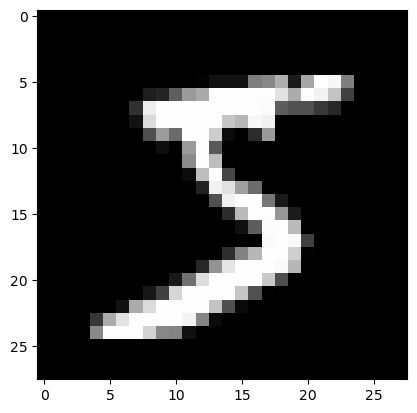

In [330]:
# Visualizando o dado da imagem

i= 0
plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
print(f'O número é o {y_train[i]}')
plt.show()

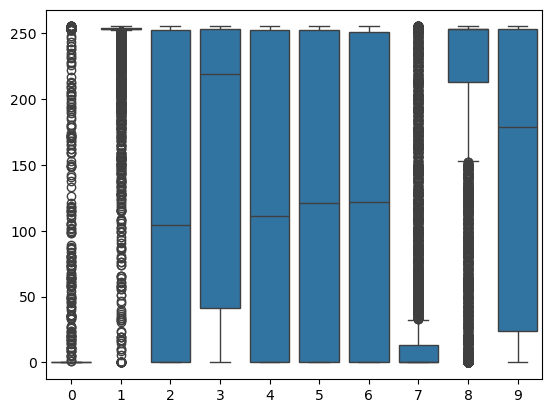

In [345]:
# Pegando um pixel e gerando um boxplot para todas as imagens
# colocando no eixo x o número que foi escrito
sns.boxplot(x=y_train, y=X_train[:,14, 14])
plt.show()

Podemos interpretar que um pixel no meio da imagem (14,14) dificilmente será um 0 ou um 1, já os demais valores apresentam possibilidades maiores de estar sendo representados.

##### Tratamento dos dados

O tratamento que vamos utilizar aqui consiste em mudar o formato do array para ter apenas uma linha e 784 colunas. Vamos fazer isto através do método ```.reshape``` do numpy:

- O objeto original é um *ndarray* de dimensões (60.000, 28, 28). Podemos entender como `60.000 matrizes de tamanho 28 x 28`.
- Vamos transformar em um *ndarray* de 2 dimensões com 60.000 linhas e 784 (= 28 x 28) colunas.

In [355]:
%%time

X_tra = X_train.reshape(X_train.shape[0], 784)
X_tst = X_test.reshape(X_test.shape[0], 784)

CPU times: total: 0 ns
Wall time: 0 ns


In [361]:
X_tra.shape, X_tst.shape

((60000, 784), (10000, 784))

In [363]:
28*28

784

#### Construindo o modelo

Como vimos há pixels informativos e não informativos. Agora vamos treinar um modelo com todos o pixels - vamos avaliar não só a acurácia, mas também quanto tempo tomamos para rodas nosso código.

In [572]:
%%time

# Definindo a RandomForest
clf = RandomForestClassifier(n_estimators=100)
# Treinando o modelo na base de testes
clf.fit(X_tra, y_train)

CPU times: total: 40.8 s
Wall time: 41.2 s


RandomForestClassifier()

##### Acurácia do modelo

A acurácia do modelo na bases de testes é: 96.94%


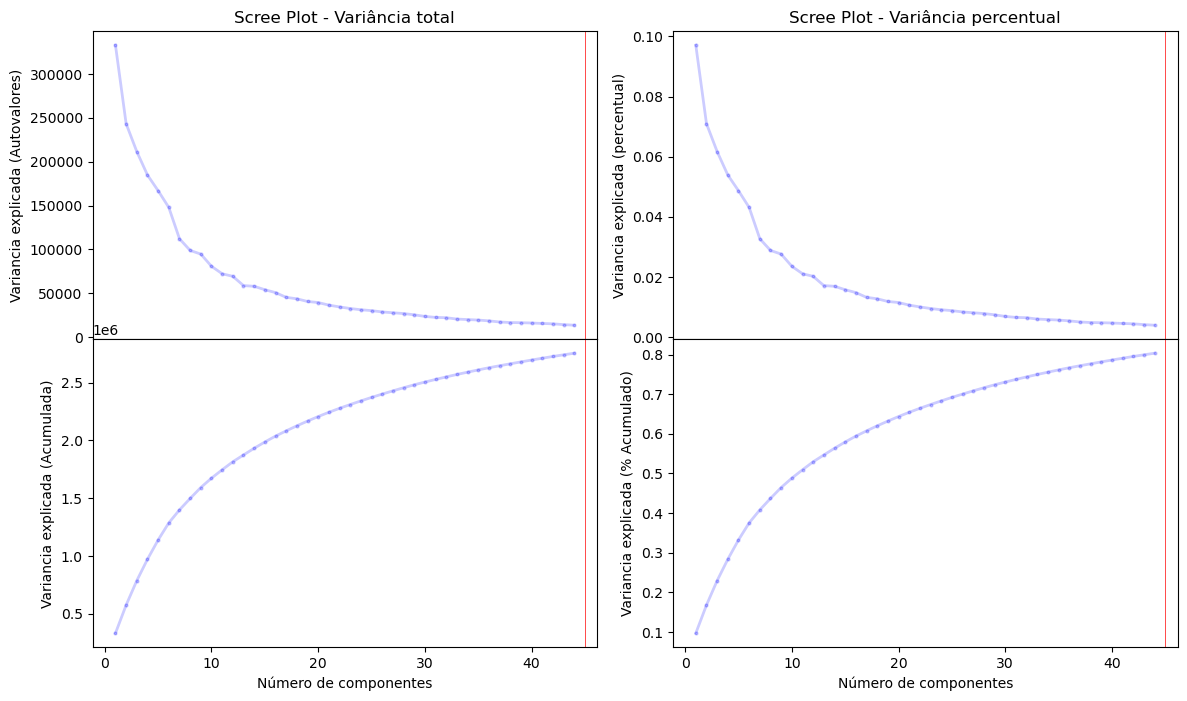

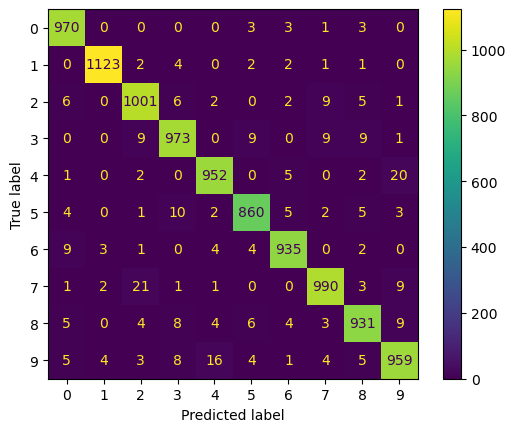

In [574]:
y_pred = clf.predict(X_tst)
print(f'A acurácia do modelo na bases de testes é: {accuracy_score(y_pred, y_test)*100}%')

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

##### Mesma estrutura considerando PCA (Principal components analysis)

- Considerando inicialmente 10 componentes principais

In [596]:
pcs = PCA().fit(X_tra)

In [597]:
def screeplot(princomp, ncomp = 0, varexplicada=0, criterio=1):
    
    if ncomp > 0:
        ncomp_crit = ncomp
    elif varexplicada > 0:
        ncomp_crit = (princomp.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1 
        # Critério 1: autovalor padronizado > 1
    elif criterio == 1:
        ncomp_crit = (princomp.explained_variance_ratio_ > 1 / princomp.n_components_).sum()
    else: ncomp_crit = None
    
    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
    plt.subplots_adjust(hspace=0, wspace=.15)


    num_componentes = np.arange(princomp.n_components_) + 1
    ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,0].set_title('Scree Plot - Variância total')
    ax[0,0].set_xlabel('Número de componentes')
    ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

    ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,0].set_xlabel('Número de componentes')
    ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


    ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,1].set_title('Scree Plot - Variância percentual')
    ax[0,1].set_xlabel('Número de componentes')
    ax[0,1].set_ylabel('Variancia explicada (percentual)')

    ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,1].set_xlabel('Número de componentes')
    ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')
    
    if ncomp_crit != None:
        # Linhas verticais de referência
        ax[0,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)


        # linhas horizontais
        variancia               = princomp.explained_variance_[ncomp_crit-1]
        variancia_acumulada     = princomp.explained_variance_.cumsum()[ncomp_crit-1]
        pct_variancia           = princomp.explained_variance_ratio_[ncomp_crit-1]
        pct_variancia_acumulada = princomp.explained_variance_ratio_.cumsum()[ncomp_crit-1]
        
        ax[0,0].axhline(y = variancia              , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axhline(y = variancia_acumulada    , color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axhline(y = pct_variancia          , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axhline(y = pct_variancia_acumulada, color = 'r', linestyle = '-', linewidth=.5)


    print(f'Número de componentes:............... {ncomp_crit}')
    print(f'Variância da ultima CP:.............. {variancia:.2f}' )
    print(f'Variância total explicada:........... {variancia_acumulada:.2f}' )
    print(f'Variância percentual da última CP:... {100*pct_variancia:.2f}%' )
    print(f'Variância percentual total explicada: {100*pct_variancia_acumulada:.2f}%' )
    plt.show()
    return ncomp_crit

Número de componentes:............... 44
Variância da ultima CP:.............. 13652.82
Variância total explicada:........... 2754084.42
Variância percentual da última CP:... 0.40%
Variância percentual total explicada: 80.33%


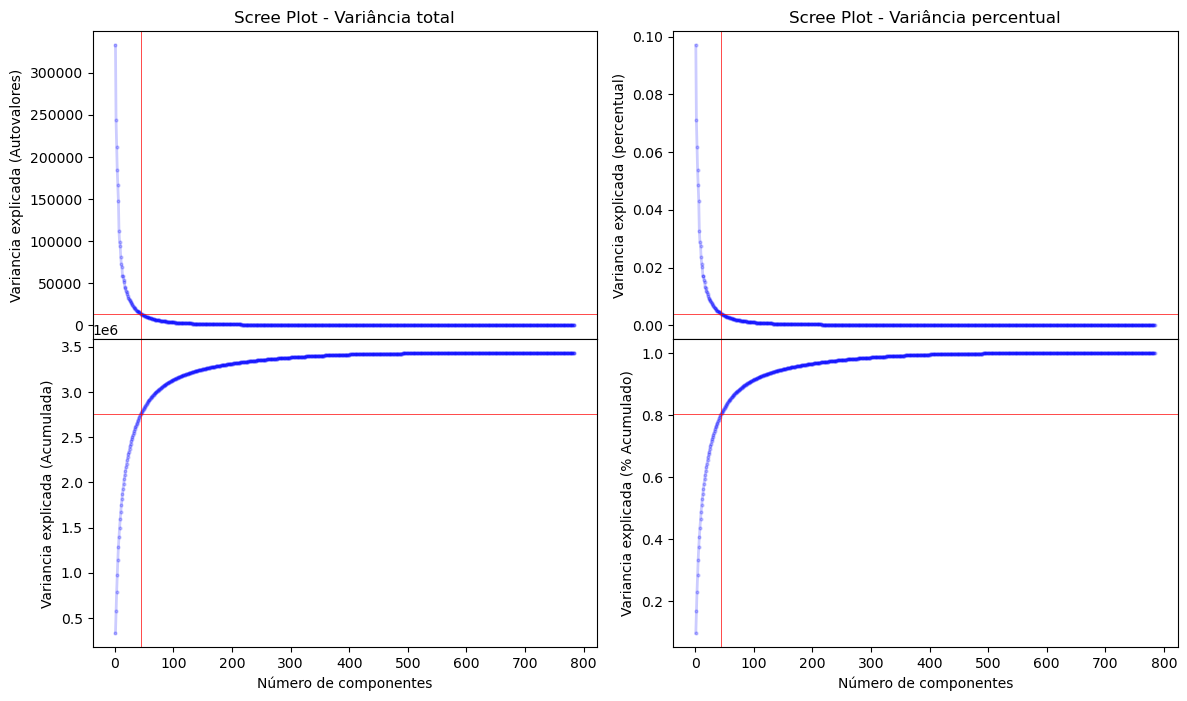

In [598]:
# Rodando a função 
ncomp = screeplot(pcs, varexplicada=.8) # explicando pelo menos 80% da variância

In [599]:
%%time
# Aplicando as componentes principais nas bases de treino e teste

pcs = PCA(n_components = ncomp).fit(X_tra)

cps_train = pcs.transform(X_tra)
cps_test = pcs.transform(X_tst)

CPU times: total: 9.84 s
Wall time: 1.88 s


##### Análise descritiva das componentes

Será que conseguimos uma boa discriminação utilizado as componentes principais? Vamos dar uma olhada na distribuição da primeira componente para cada dígito

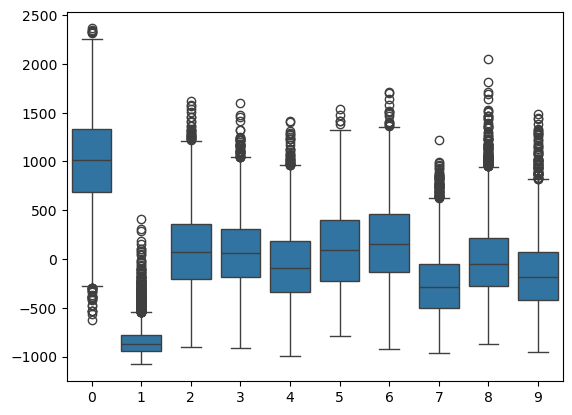

In [601]:
sns.boxplot(x=y_train, y=cps_train[:,0])
plt.show()

Ou seja, em uma análise inicial pode-se dizer que a primeira componente principal consegue discriminar bem o 0 e o 1, mas vamos adiante...

##### Construindo um modelo com PCA

Construindo uma RandomForest com as componentes principais

In [604]:
cps_train.shape

(60000, 44)

In [605]:
%%time

# Criando a RandomForest
clf = RandomForestClassifier(n_estimators=100)

# Treinando o modelo
clf.fit(cps_train, y_train)

CPU times: total: 54.8 s
Wall time: 55.3 s


RandomForestClassifier()

##### Avaliando a acurácia do modelo com PCA

Dado o ganho de no tempo de execução, talvez seja aceitável alguma perda na acurácia. Vejamos...

A acurácia na base de testes é: 95.56%


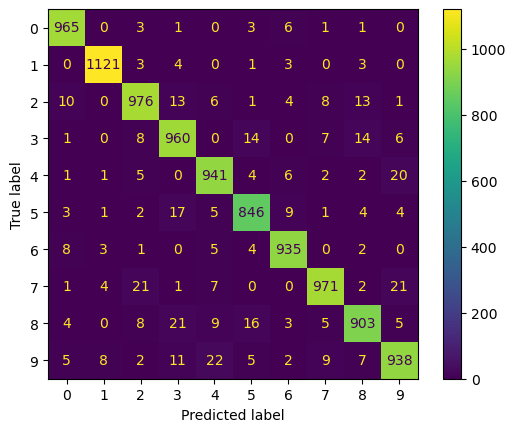

In [607]:
y_pred = clf.predict(cps_test)
print(f'A acurácia na base de testes é: {accuracy_score(y_pred, y_test)*100}%')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

#### Avaliando a correlação das componentes com os pixels


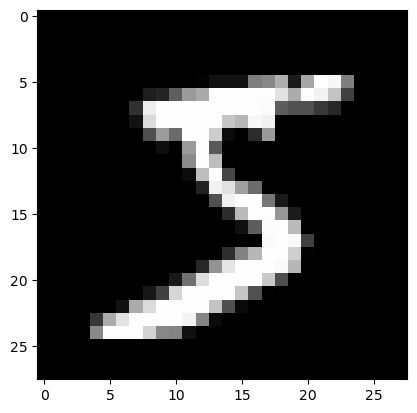

In [609]:
plt.imshow(X_tra[0].reshape([28,28]), cmap=plt.get_cmap('gray'))
plt.show()

In [610]:
X_trcp = pd.concat([pd.DataFrame(cps_train), pd.DataFrame(X_tra)],axis=1)
X_trcp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,123.932589,312.674262,24.514052,555.757958,-27.296668,232.476284,233.995733,159.799494,-363.515021,198.428077,-197.497025,-254.055913,113.496409,749.302451,-219.259554,4.693241,-330.151992,309.153886,277.593870,166.332371,-27.541857,-64.353307,217.178328,-250.244425,-46.166068,100.339444,308.006769,170.105133,-125.514290,-123.399691,-97.957947,34.575191,-107.484335,84.598468,-152.403071,-200.802897,-65.240800,-200.219128,-157.660546,-359.742861,185.587109,-154.450111,40.242631,84.965855,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0,0,0

In [611]:
cor_cp = X_trcp.corr().iloc[10:, :10].to_numpy()
cor_cp.shape

(818, 10)

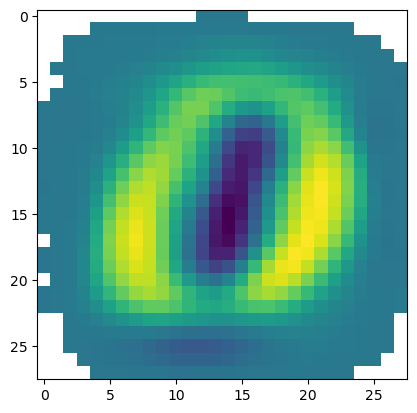

In [612]:
plt.imshow(cor_cp[34:,0].reshape(28,28))
plt.show()

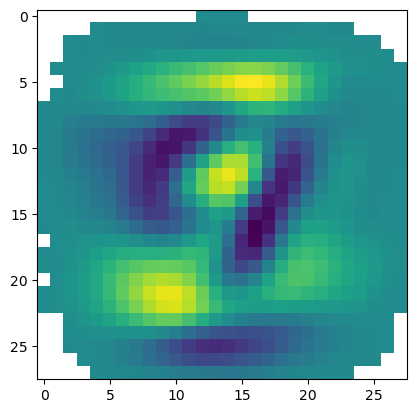

In [613]:
plt.imshow(cor_cp[34:,1].reshape(28,28))
plt.show()

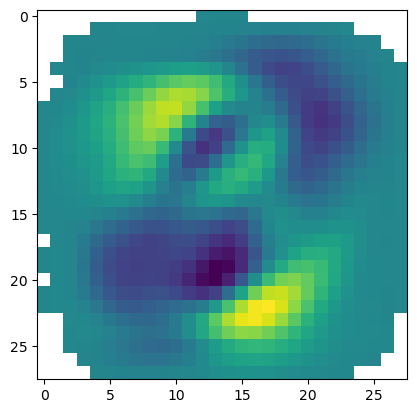

In [614]:
plt.imshow(cor_cp[34:,2].reshape(28,28))
plt.show()

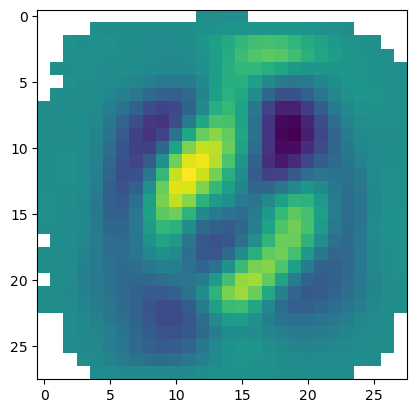

In [615]:
plt.imshow(cor_cp[34:,5].reshape(28,28))
plt.show()

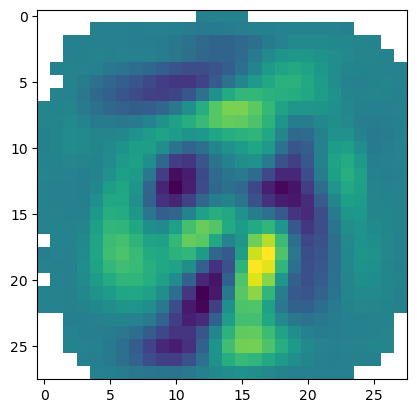

In [616]:
plt.imshow(cor_cp[34:,9].reshape(28,28))
plt.show()

In [617]:
cor_cp[34:,3].shape

(784,)